# Deep learning solution method with all-in-one expectation operator

This is a JAX version using FLAX for neural networks and Optax for the
optimization.

Similar code can be found for
[tensorflow](https://notes.quantecon.org/submission/5ddb3c926bad3800109084bf)
and
[torch](https://notes.quantecon.org/submission/65449f6b8f6a1a0016fc4544)

-   This companian notebook illustrates a deep learning framework for
    solving dynamic economic models introduced by Maliar, Maliar and
    Winant (2018, 2019) in the paper “Will Artificial Intelligence
    Replace Computational Economists Any Time Soon?”.
-   In the paper, we offer a unified approach for casting three
    fundamental objects of economic dynamics – lifetime reward, Bellman
    equation and Euler equation – into objective functions of the deep
    learning framework.
-   In the notebook, we illustrate only one of the three approaches –
    the Euler residual minimization.
-   We solve a cannonical consumption-saving problem with occasionally
    binding borrowing constraint and four exogenous stochastic shocks.
-   We parameterize the agent’s decision function with a multilayer
    neural network, and we perform training using stochastic
    optimization, namely, in each iteration, we train the model on just
    one or few grid points that are randomly drawn from the state space
    (instead of using a conventional fixed grid with a potentially large
    number of grid points).
-   Our objective function – the sum of squared residuals in the Euler
    equation – has two types of expectation operators, one is with
    respect to current state variables (which arises because grid points
    that are randomly drawn from the state space), and the other is with
    respect to future state variables (which arises because next-period
    shocks are randomly drawn from the given distributions).
-   We construct all-in-one expectation method that merges the two
    expectation operators into one. Namely, we use two independent
    random draws for evaluating two terms of a squared residual – this
    method eliminates the correlation between the terms and pulls the
    expectation operator out of the square. Our all-in-one expectation
    operator allows for efficient parallel calculations and reduces
    greately the cost of training deep neural networks.

## JAX and libraries

JAX

In [9]:
import jax
import flax
import optax
from jax import numpy as jnp
from typing import Any, Callable, Sequence


This notebook uses several libraries. A missing library x can be
installed using `pip install x`

In [10]:
import numpy as np
# from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm         # tqdm is a nice library to visualize ongoing loops
import datetime
# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass

## The model

We consider the following consumption-saving problem:

where $c_{t}$ is consumption; $w_{t}$ is the beginning-of-period
cash-on-hand; $\beta \in \left[ 0,1\right)$ is a subjective discount
factor; $\overline{r}\in \left( 0,\frac{1}{\beta }\right)$ is a (gross)
constant interest rate; and initial condition $\left( z,w\right)$ is
given. There is an occasionally binding inequality constraint:
consumption $c_{t}$ cannot exceed cash-on-hand $w_{t}$. There are four
different exogenous state variables, namely, shocks to the interest rate
($r_{t}$), discount factor ($\delta_t$), transitory component of income
$q_{t}$ and permanent component of income $p_{t}$. The total income is
$y_{t}=p_{t}q_{t}$. All exogenous variables follows AR(1) processes:

where $\epsilon_t \sim \mathcal{N}\left( 0,1\right)$. We assume the
Cobb-Douglas utility function
$u\left( {c_{t}}\right) =\frac{1}{1-\gamma }\left( c_{t}^{1-\gamma }-1\right)$.
The model’s parameters are specified below.

In [11]:
# Model parameters

β = 0.9 
γ = 2.0 
# σ = 0.1  
# ρ = 0.9
σ_r = 0.001
ρ_r = 0.2
σ_p = 0.0001
ρ_p = 0.999
σ_q = 0.001
ρ_q = 0.9
σ_δ = 0.001
ρ_δ = 0.2
rbar = 1.04

## Stochastic solution domain

We solve the model on a random grid which is drawn from the following
domain:

-   for AR1 processes, we take the ergodic distribution (recall that for
    an AR(1) process $z$ with autocorrelation $\rho$ and conditional
    standard deviation $\sigma$, the ergodic distribution is normal with
    zero mean and standard deviation
    $\sigma_z= \frac{\sigma}{\sqrt{1-\rho^2}}$.
-   for available income we choose a uniform distribution between two
    finite bounds: $w\in[w_{\min}, w_{\max}]$.

In [12]:
# Standard deviations for ergodic distributions of exogenous state variables
σ_e_r = σ_r/(1-ρ_r**2)**0.5
σ_e_p = σ_p/(1-ρ_p**2)**0.5
σ_e_q = σ_q/(1-ρ_q**2)**0.5
σ_e_δ = σ_δ/(1-ρ_δ**2)**0.5

# bounds for available income
wmin = 0.1
wmax = 4.0

## Kuhn-Tucker conditions

In the recursive form, the solution can be characterized by the
Kuhn-Tucker (KT) conditions where $a$ is the share of income that goes
to savings and $b$ is the Lagrange multiplier (In the absence of
borrowing constraint $b=0$, the KT conditions lead to the familiar Euler
equation).

Inequality constraints are not directly compatible with the deep
learning framework developed in the paper, so we reformulate the KT
conditions as a set of equations that hold with equality. We use a
smooth representation of the KT conditions, called the
Fischer-Burmeister (FB) function, which is differentiable The
restriction $FB\left( a,b\right) =0$ is also equivalent to the KT
conditions.

For numerical treatment, we rewrite the FB function in the following
unit-free form where $\zeta$ and $h$ are respectively the consumption
share and normalized Lagrange multiplier In particular, $\zeta$ belongs
to the interval $\left[0,1\right]$ which is a convenient domain for
defining neural network. In turn, $h$ is normalized to be around one: we
will parameterize it with neural network in the way that ensures that it
is nonnegative.

In [13]:
# here are the Fisher Burmeister functions with JAX
min_FB = lambda a,b: a+b-jnp.sqrt(a**2+b**2)
max_FB = lambda a,b: -min_FB(-a,-b)

## Parameterizing decision functions with neural network

There are many different decision functions that we can approximate for
characterizing the solution, including consumption, next-period income,
etc. We chose to approximate the two functions that we defined earlier:
the share of consumption, $\zeta \equiv \frac{c}{w}$, and the normalized
Lagrange multiplier $h$. Since the model is stationary, we look for a
decision rule where $s=(r, \delta, q, p, w)$ is the 5-dimensional state
space, and $\varphi$ is a function to be determined.

A common approach in computational economics is to approximate an
unknown function $\varphi$ using some flexible function family
$\varphi(...;\theta)$ parameterized by a vector of coefficients
$\theta$, e.g., a polynomial family. Neural networks are just a special
family of approximating functions. A distinctive feature of neural
networks is that they have a nonlinear dependence of the approximation
function on the coefficients $\theta$. TensorFlow contains a submodule
keras, which makes it easy to build such a network. Below, we build the
multilayer perceptrion: a 2 hidden layers 32x32x32x2 network with relu
activation functions and linear outputs.

In [14]:
import flax
from flax import nnx # old API
from flax import linen as nn # new stateless API

In [15]:
class MLP(nn.Module):
  
  def __init__(self):
    self.linear1 = nn.Dense(32)
    self.linear2 = nn.Dense(32)
    self.linear3 = nn.Dense(32)
    self.linear4 = nn.Dense(2)

  def __call__(self, x: jax.Array):
    x = nnx.relu(self.linear1(x))
    x = nnx.relu(self.linear2(x))
    x = nnx.relu(self.linear3(x))
    x = self.linear4(x)
    return x
  

In [17]:
class ExplicitMLP(nn.Module):
  features: Sequence[int]

  def setup(self):
    # we automatically know what to do with lists, dicts of submodules
    self.layers = [nn.Dense(feat) for feat in self.features]
    # for single submodules, we would just write:
    # self.layer1 = nn.Dense(feat1)

  def __call__(self, inputs):
    x = inputs
    for i, lyr in enumerate(self.layers):
      x = lyr(x)
      if i != len(self.layers) - 1:
        x = nn.relu(x)
    return x


In [18]:
# this creates a 3 layer perceptron with 32 neurons on each.
model = ExplicitMLP(features=[32,32,32,2])


In [22]:
initial_key = jax.random.PRNGKey(0)

In [23]:
# the following code initializes the neural network with random values
key1, key2 = jax.random.split(initial_key, 2)
(key1, key2)

(Array([4146024105,  967050713], dtype=uint32),
 Array([2718843009, 1272950319], dtype=uint32))

In [24]:

x = jax.random.uniform(key1, (5,))
theta_0 = model.init(key2, x)
# all the trainable parameters of the NN are stored in theta_0
# it is a "pytree", that we will be able to use to compute gradients

In [27]:
theta_0

{'params': {'layers_0': {'kernel': Array([[ 2.89577007e-01,  6.11086428e-01,  4.29756224e-01,
           -6.59482032e-02,  6.01531386e-01, -7.20138252e-02,
            3.17190468e-01, -5.11465132e-01, -3.15770417e-01,
           -8.75175148e-02,  5.98206967e-02,  4.34658617e-01,
            6.40521586e-01,  3.27503353e-01, -6.04019523e-01,
           -4.88558829e-01,  3.26692939e-01, -1.13124512e-02,
           -5.08673668e-01,  2.98018754e-01,  8.51716101e-01,
            5.67055419e-02,  1.12907700e-01,  3.46427590e-01,
            1.41134754e-01,  6.73149973e-02, -4.25780952e-01,
            2.86633670e-01,  3.67178358e-02, -2.31897891e-01,
            2.35282540e-01, -6.77139223e-01],
          [ 6.85976148e-01,  2.81706750e-01,  2.74065614e-01,
            7.59876728e-01,  3.24741960e-01,  5.63200474e-01,
           -6.12043560e-01, -4.05330420e-01, -2.18019247e-01,
           -2.88477540e-01,  3.13743562e-01,  3.63510489e-01,
           -2.44555622e-01, -8.66781831e-01,  5.651363

In [25]:
#  pretty print requres the library `treescope` to be installed
nnx.display(model)

Next, we create the decision rule which takes as input 5 vectors of the
same size $n$ for the states $r$, $\delta$, $q$, $p$, $w$ and returns
two vectors of size $n$ for $\zeta$ and $h$, respectively. We use
different nonlinear transformation for the two decision functions:

where nn denotes neural network; the first and second elements in the
vector function $\varphi$ are used to get $\zeta\in[0,1]$ and $h>0$,
respectively.

In [ ]:
def dr(theta, r: Vector, p: Vector, q: Vector, δ: Vector, w: Vector)-> Tuple[Vector, Vector]:

    # we normalize exogenous state variables by their 2 standard deviations 
    # so that they are typically between -1 and 1 
    r = r/σ_e_r/2
    δ = δ/σ_e_δ/2
    q = q/σ_e_q/2
    p = p/σ_e_p/2
    
    # we normalze income to be between -1 and 1
    w = (w-wmin)/(wmax-wmin)*2.0-1.0

    # we prepare input to the perceptron
    # s = tf.(concat[_e[:,None] for _e in [r,p,q,δ,w]], axis=1) # equivalent to np.column_stack
    
    s = jnp.column_stack([r,p,q,δ,w])

    x = model.apply(theta, s) # n x 2 matrix 

    # consumption share is always in [0,1]
    ζ = jax.nn.sigmoid( x[:,0] )
    
    # expectation of marginal consumption is always positive
    h = jnp.exp( x[:,1] )
    
    return (ζ, h)

Finally, as an illustration, we plot the initial guess of decision rules
against $w$. Note that the coefficients of the perceptron are
initialized with random values, so that each run will provide a
different plot. Here, we are using TensorFlow in an eager mode, i.e.,
calculations are returned immediately, so that the library essentially
behaves in the same way as numpy, and is in fact mostly compatible with
it.

In [28]:
wvec = jnp.linspace(wmin, wmax, 100)
# r,p,q,δ are zero-mean
ζvec, hvec = dr(theta_0, wvec*0, wvec*0, wvec*0, wvec*0, wvec)

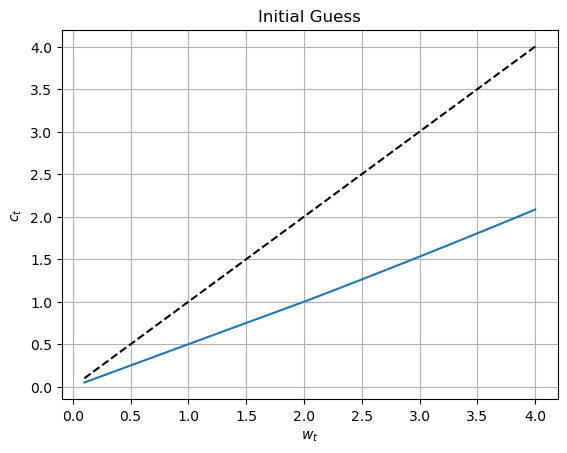

In [29]:
plt.plot(wvec, wvec, linestyle='--', color='black')
plt.plot(wvec, wvec*ζvec)
plt.xlabel("$w_t$")
plt.ylabel("$c_t$")
plt.title("Initial Guess")
plt.grid()

## Residuals in the model’s equations

To identify the unknown decision functions for $\zeta$ and $h$, we use
two modelp’s equations, namely, the definition of normalized Lagrange
multiplier and the FB function representing the KT conditions,
respectively: where
$\epsilon=(\epsilon_r,\epsilon_\delta,\epsilon_q,\epsilon_p)$.

We do not need to include the definition $\zeta = \frac{c}{w}$ because
we will impose it to hold exactly in the solution by setting $c=w\zeta$
and $c^{\prime}=w^{\prime}\zeta ^{\prime}$.

We next construct the residuals in the above two equations which we will
minimize. For given vectors of next-period shocks
$\epsilon=(\epsilon_r,\epsilon_\delta,\epsilon_q,\epsilon_p)$, state
$s=(r,\delta ,q,p,w)$ and next-period shocks, we define: where the
transition equation is $w^{\prime }=\left( w-c\right) \overline{r%
}\exp (r)+\exp (y)$.

In [35]:
def Residuals(theta, e_r: Vector, e_p: Vector, e_q: Vector, e_δ: Vector, r: Vector,  p: Vector, q: Vector, δ: Vector,  w: Vector):

    # all inputs are expected to have the same size n
    n = r.shape[0]

    # arguments correspond to the values of the states today
    ζ, h = dr(theta, r, p, q, δ, w)
    
    c = ζ*w

    # transitions of the exogenous processes
    rnext = r*ρ_r + e_r
    pnext = p*ρ_p + e_p
    qnext = q*ρ_q + e_q
    δnext = δ*ρ_δ + e_δ

    # (epsilon = (rnext, δnext, pnext, qnext))
    
    # transition of endogenous states (next denotes variables at t+1)
    wnext = jnp.exp(pnext)*jnp.exp(qnext) + (w-c)*rbar*jnp.exp(rnext)

    ζnext, hnext = dr(theta, rnext, pnext,  qnext, δnext,  wnext)
    cnext = ζnext*wnext


    R1 = β*jnp.exp(δnext-δ)*(cnext/c)**(-γ)*rbar*jnp.exp(rnext) - h
    R2 = min_FB(1-h,1-ζ)

    return (R1, R2)

## The expected squared sum of residuals

We construct the objective function for minimization as the squared sum
of two residuals in the two model’s equations on a given 5-dimensional
domain $s=(r,\delta ,q,p,w)$: where $v$ is the exogenous relative
weights of the two residuals in the objective function. We placed the
first residual $R_1(s,\epsilon)$ under the expectation operator
$E_{\epsilon }$ across next-period shocks \$=( *{r},*{},*{q},*{p}) \$ as
is required by the definition of $h$; the second residual $R_2(s)$ does
not include random variables  
and requires no expectation operator. The value of the objective
function $\Xi (\theta )$ depends on the coefficients \$\$ because these
coefficients determine the choices via  
A shortcoming of the constructed objective function is that it requires
a potentially costly evaluation of two nested expectation operators: for
each random grid point $s=(r,\delta ,q,p,w)$, we need to construct a
separate approximation of the expectation function \$E\_{}\$ by
considering a potentially large number of next period shocks \$=( *{r},
*{},*{q},*{p}) $. In particular, if there are$n\$ grid points and $J$
next-period shocks, we have $n\times J$ function evaluations.

## All-in-one expectation function

We now introduce a technique which we call an all-in-one expectation
operator that makes it possible to merge the two expectation operators
into a single one. This technique relies on a simple result from
probability theory that says that for two random variables $a$ and $b$,
which are independent and follow the same distribution, we have
$E[a]^{2}=E[a]E[b]=E[ab]$.

Therefore, we replace
$\left( E_{\epsilon }\left[ \left. R_1(s,\epsilon)\right\vert
\epsilon \right] \right) ^{2}$ by the product of two residuals
constructed by using two uncorrelated random draws $\epsilon _{1}$ and
$\epsilon _{2}$, and as a result, we can pull the expectation out of
squares With that result, we can re-write the objective function as just
one expectation operator: where
$\omega =(s,\epsilon _{1},\epsilon _{2})$. Therefore, we wrote the
objective function of the deep learning method as a single expectation
operator \$E\_{}\$ of a function $%
\xi (\omega ;\theta )$ that depends on a vector-valued random variable
\$% \$. We approximate $\Xi (\theta )$ by using Monte Carlo simulation:
i.e., we draw $n$ random draws of
$\omega =(s,\epsilon _{1},\epsilon _{2})$ and compute the average of the
objective function.

In [36]:
def Ξ(n, theta, key): # objective function for DL training

    keys = jax.random.split(key, 13)

    # randomly drawing current states
    r = jax.random.normal(keys[0], shape=(n,))*σ_e_r
    p = jax.random.normal(keys[1], shape=(n,))*σ_e_p
    q = jax.random.normal(keys[2], shape=(n,))*σ_e_q
    δ = jax.random.normal(keys[3], shape=(n,))*σ_e_δ

    w = jax.random.uniform(keys[4], shape=(n,), minval=wmin, maxval=wmax)
 
    # randomly drawing 1st realization for shocks
    e1_r = jax.random.normal(keys[5], shape=(n,))*σ_r
    e1_p = jax.random.normal(keys[6], shape=(n,))*σ_p
    e1_q = jax.random.normal(keys[7], shape=(n,))*σ_q
    e1_δ = jax.random.normal(keys[8], shape=(n,))*σ_δ

    # randomly drawing 2nd realization for shocks
    e2_r = jax.random.normal(keys[9], shape=(n,))*σ_r
    e2_p = jax.random.normal(keys[10], shape=(n,))*σ_p
    e2_q = jax.random.normal(keys[11], shape=(n,))*σ_q
    e2_δ = jax.random.normal(keys[12], shape=(n,))*σ_δ
    
    
    # residuals for n random grid points under 2 realizations of shocks
    R1_e1, R2_e1 = Residuals(theta, e1_r, e1_p, e1_q, e1_δ, r, p, q, δ, w)
    R1_e2, R2_e2 = Residuals(theta, e2_r, e2_p, e2_q, e2_δ, r, p, q, δ, w)

    # construct all-in-one expectation operator
    R_squared = R1_e1*R1_e2 + R2_e1*R2_e2 
    
    # compute average across n random draws
    return jnp.mean(R_squared)


So far, we have been using JAX in the eager execution mode as if it was
numpy: result of each operation is computed immediately.

In [41]:
n = 128
key = jax.random.key(19)
v = Ξ(n, theta_0, key)
v

Array(0.4020505, dtype=float32)

Note that the intermediate results are still stored as special JAX
objects (tensors) and they can be converted to a regular value easily.

In [64]:
float(v)

0.3263273239135742

# Model training

We are now ready to perform minimization of the objective $\Xi_n$, hence
to solve (or to train) the model using stochastic optimization - the
stochastic gradient descent method, and in particular, its version
called Adam.

Now it is time to choose an optimizer. In TensorFlow, the optimizer
object is in charge of performing the optimization steps, given the
computed gradient. For the stochastic gradient descent, the updating
rule would be:
$$\theta \leftarrow \theta(1-\lambda) - \lambda\nabla_{\theta} \Xi_n(\theta)$$
where $\lambda$ is a learning rate. For Adam, the learning rate evolves
over time and can be specific to each coefficient.

In [42]:
import optax


In [44]:
optimizer = optax.adam(1e-3) 
opt_state = optimizer.init(theta_0)


In [46]:
@nnx.jit  # Automatic state management
def train_step(theta, opt_state, key):

  n = 128
  def loss_fn(theta):
    return Ξ(n, theta, key)

  loss, grads = nnx.value_and_grad(loss_fn)(theta)

  updates, opt_state = optimizer.update(grads, opt_state)
  theta = optax.apply_updates(theta, updates)

  return theta, opt_state, loss

In [48]:
key = jax.random.key(0)
train_step(theta_0, opt_state, key)

({'params': {'layers_0': {'bias': Array([-0.00099999,  0.00099999, -0.00099999, -0.00099999, -0.00099999,
           -0.00099999,  0.00099998, -0.00099999, -0.00099999, -0.00099999,
            0.00099999, -0.00099999, -0.00099984,  0.00099999, -0.00099999,
           -0.00099998,  0.00099999, -0.00099999,  0.00099999,  0.00099999,
            0.00099999,  0.00099999, -0.00099999,  0.00099999,  0.00099999,
            0.00099999,  0.00099999, -0.00099999, -0.00099999, -0.00099999,
            0.00099999, -0.00099999], dtype=float32),
    'kernel': Array([[ 2.90576994e-01,  6.10086501e-01,  4.28756237e-01,
            -6.69481903e-02,  6.00531399e-01, -7.30138049e-02,
             3.16190541e-01, -5.10465145e-01, -3.16770405e-01,
            -8.65175277e-02,  6.08206876e-02,  4.35658604e-01,
             6.39521599e-01,  3.28503340e-01, -6.03019536e-01,
            -4.87558842e-01,  3.27692926e-01, -1.23124393e-02,
            -5.09673655e-01,  2.97018766e-01,  8.52716088e-01,
         

We repeat the training_step K times with the following function (each
training step is called an epoch).

In [49]:
def train_me(K, key, theta_0, opt_state):

    theta = theta_0

    key, key_ = jax.random.split(key)
    
    vals = []
    for k in tqdm(range(K)):
        theta, opt_state, val = train_step(theta, opt_state, key)
        

        vals.append(float(val))
        key, key_ = jax.random.split(key)

    return vals, theta

In [50]:
# with writer.as_default():
key0 = jax.random.key(43)
results, theta = train_me(50000, key0, theta_0, opt_state)

100%|██████████| 50000/50000 [01:33<00:00, 534.71it/s]

On a modern cpu, optimization should be done within few minutes. It
would be dramatically faster on hardware adapted to deep-learning. To
see how the training has performed, we can plot the empirical errors
against the number of epochs.

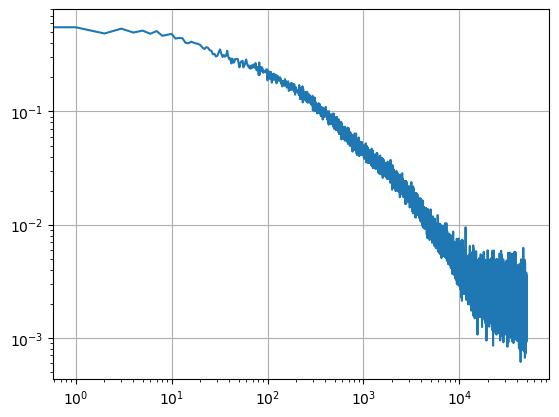

In [51]:
plt.plot(np.sqrt( results) )
plt.xscale('log')
plt.yscale('log')
plt.grid()

In the training graph, one can see that errors are decreasing until they
reach $2*10^{-3}$ on average (the errors are volatile both because they
depend on a specific random draw and because only two such random draws
are used to approximate the expectation function). The numbers in the
graph represent the mean of the squared residuals. We show the
constructed decision rule below.

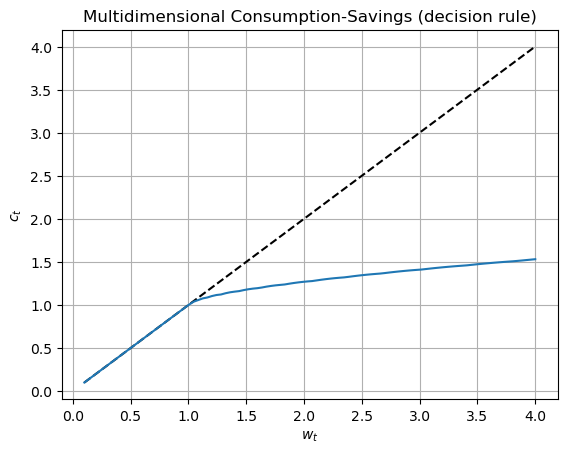

In [52]:
wvec = np.linspace(wmin, wmax, 100)
ζvec, hvec = dr(theta, wvec*0, wvec*0, wvec*0, wvec*0, wvec)

plt.title("Multidimensional Consumption-Savings (decision rule)")
plt.plot(wvec, wvec, linestyle='--', color='black')
plt.plot(wvec, wvec*ζvec)
plt.xlabel("$w_t$")
plt.ylabel("$c_t$")
plt.grid()